You can use this notebook to write the ML pipeline for the classification of the galaxies in the GALAXYZOO dataset or create a folder with different files associated to the different steps of the ML pipeline.

In [1]:
#Importing libraries

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Downloading the Galaxy Zoo Dataset

You can find the dataset from the Github repository at the url:



https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data

---

#### Create a data frame with columns for objid and the corresponding asset_id.  
- asset_id: an integer that corresponds to the filename of the image of a particular galaxy.
- objid is the designation of the galaxy, e.g. galaxy 587722981741363294

In [2]:
import pandas as pd 

# get the objid and corresponding asset_id from gz2_filename_mapping.csv
columns_to_keep = ['objid', 'asset_id']

# Read the selected columns from the file
name_map = pd.read_csv("data/gz2_filename_mapping.csv", usecols=columns_to_keep)

# display the first few rows
# print(name_map.head(5))

#name_map.info()

---

#### Create a data frame with dr7objid and corresponding label. 
- dr7objid gives the galaxy designation same as objid from the previous data frame.
- label correspond to some classification of the galaxy based on its shape and morphology. 

In [54]:
# select columns dr7objid and gz2class from zoo2MainSpecz.csv
columns_to_keep = ['dr7objid', 'gz2class']

# Read the selected columns from the file
labels = pd.read_csv("data/zoo2MainSpecz.csv", usecols=columns_to_keep)

# change the name of column dr7objid to objid for merging later
labels.rename(columns={'dr7objid':'objid'}, inplace=True)

# display
print(labels.head(5))

#labels.info()
print(labels["gz2class"].str[:2].replace(r"\bS[a-z]", "S", regex = True).unique())
temp = labels["gz2class"].str[:2].replace(r"\bS[a-z]", "S", regex = True)
temp[temp == 'A']

                objid gz2class
0  588017703996096547    SBb?t
1  587738569780428805      Ser
2  587735695913320507     Sc+t
3  587742775634624545   SBc(r)
4  587732769983889439      Ser
['SB' 'S' 'Ec' 'Ei' 'Er' 'A']


30        A
194       A
709       A
1562      A
2121      A
         ..
239186    A
239593    A
240101    A
240713    A
242482    A
Name: gz2class, Length: 247, dtype: object

---

### 1. Convert array of pixels in rows of a tabular dataset,using single pixels as feature columns and the intensities as values measured (Chris)

In [38]:
# load and processing images, convert to grayscale and flattening pixel. 

from src.data_processing import process_image_seq # sequentially load one image ata time 

# Directory containing the images
image_dir = "data/images"

# call the sequential function
image_data = process_image_seq(image_dir)

#display the data frame
#print(image_data.head())
#image_data.info()

# Save to CSV
#image_data("image_pixel_data.csv", index=False)

  asset_id  0  1  2  3  4  5  6  7  8  ...  179766  179767  179768  179769  \
0    87384  4  4  2  1  0  0  0  0  1  ...       7       9      13      10   
1   165078  0  0  0  1  3  5  7  8  2  ...       4       4       2       2   
2   155364  5  6  7  7  7  7  6  5  5  ...      12      13      20      21   
3   261278  0  0  1  1  1  1  1  1  5  ...       6       3       5       8   
4   227960  3  3  3  2  2  1  1  1  1  ...       9      10      11      12   

   179770  179771  179772  179773  179774  179775  
0       4       1       1       3       7      11  
1       2       3       3       4       4       5  
2      20      17      13       9       7       7  
3      10      10       7       4       2       2  
4      13      14      14      14      13      13  

[5 rows x 179777 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 179777 entries, asset_id to 179775
dtypes: object(1), uint8(179776)
memory usage: 17.1+ MB


In [5]:
# Merge labels and name_map dataframes to map asset_id to gz2class
# merge based on objid. use an inner join (only matching rows) 
# since only a subset of points in labels are in name_map, ann inner join 
# will include the rows from name_map that have matching gz2class values
# this will avoid NaNs

labels_mapped = pd.merge(name_map, labels, on='objid', how='inner' ) 

#print(labels_mapped.head(5))

#labels_mapped.info() # should have the same number of rows as the dataframe labels


In [6]:
# Merge labels_mapped with image_data to insert gz2class columnt to the latter 
# Merge based on asset_id and use an inner join. image_data which is our 
# main data frame will only have, in general, a subset of data points (galaxies)
# in labels_mapped. 

# convert asset_id values in image_data from object to int64 before merging
image_data['asset_id'] = labels_mapped['asset_id'].astype(int)

#merge
galaxy_data = pd.merge(labels_mapped, image_data, on='asset_id', how='inner' ) 

# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

# print
print(galaxy_data.head(5))

galaxy_data.info()


                objid  asset_id  0  1  2  3  4  5  6  7  ...  179767  179768  \
0  587722981741363294         3  4  4  2  1  0  0  0  0  ...       9      13   
1  587722981741363323         4  0  0  0  1  3  5  7  8  ...       4       2   
2  587722981741559888         5  5  6  7  7  7  7  6  5  ...      13      20   
3  587722981741625481         6  0  0  1  1  1  1  1  1  ...       3       5   
4  587722981741625484         7  3  3  3  2  2  1  1  1  ...      10      11   

   179769  179770  179771  179772  179773  179774  179775  gz2class  
0      10       4       1       1       3       7      11        Ei  
1       2       2       3       3       4       4       5        Sc  
2      21      20      17      13       9       7       7        Er  
3       8      10      10       7       4       2       2        Er  
4      12      13      14      14      14      13      13        Ei  

[5 rows x 179779 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
C

In [7]:
from dask import delayed, compute
import os 
from PIL import Image, ImageOps
from numpy import asarray

In [8]:
# parallel implementation of processing the images with DASK

from src.data_processing import process_image_dask

# Directory containing images
image_dir = "data/images"

# Get list of image file paths
image_files = [
    os.path.join(image_dir, f) for f in os.listdir(image_dir)
    if f.endswith(('.png', '.jpg'))
]

# Parallel execution using Dask
delayed_results = [process_image_dask(img) for img in image_files]
results = compute(*delayed_results)

# Filter out failed reads
results = [res for res in results if res is not None]

# Convert to Dask DataFrame
image_names, data = zip(*results)
image_data = pd.DataFrame(data)
image_data.insert(0, "asset_id", image_names)

#print(galaxy_data.head())

#image_data.info()

# Save to CSV
#df.to_csv("image_pixel_data.csv", index=False)
#print("Processing complete. Data saved to 'image_pixel_data.csv'.")


In [9]:
# Merge labels_mapped with image_data to insert gz2class columnt to the latter 
# Merge based on asset_id and use an inner join. image_data which is our 
# main data frame will only have, in general, a subset of data points (galaxies)
# in labels_mapped. 
# convert asset_id values in image_data from object to int64 before mergeing
image_data['asset_id'] = labels_mapped['asset_id'].astype(int)

#merge
galaxy_data = pd.merge(labels_mapped, image_data, on='asset_id', how='inner') 

# Move gz2class to the last position to serve as labels
galaxy_data['gz2class'] = galaxy_data.pop('gz2class')  

# print
print(galaxy_data.head(5))

galaxy_data.info()

                objid  asset_id  0  1  2  3  4  5  6  7  ...  179767  179768  \
0  587722981741363294         3  4  4  2  1  0  0  0  0  ...       9      13   
1  587722981741363323         4  0  0  0  1  3  5  7  8  ...       4       2   
2  587722981741559888         5  5  6  7  7  7  7  6  5  ...      13      20   
3  587722981741625481         6  0  0  1  1  1  1  1  1  ...       3       5   
4  587722981741625484         7  3  3  3  2  2  1  1  1  ...      10      11   

   179769  179770  179771  179772  179773  179774  179775  gz2class  
0      10       4       1       1       3       7      11        Ei  
1       2       2       3       3       4       4       5        Sc  
2      21      20      17      13       9       7       7        Er  
3       8      10      10       7       4       2       2        Er  
4      12      13      14      14      14      13      13        Ei  

[5 rows x 179779 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
C

---

### 2. Perform EDA and feature preprocessing (Nisha)
#### 2.1 Exploratory Data Analysis (EDA)

In [10]:
# print
#print(galaxy_data.head(4))

print(galaxy_data.shape)  # Check dimensions

galaxy_data.info()# Check data types & missing values

print(galaxy_data.describe())  # Get summary stats

(100, 179779)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 179779 entries, objid to gz2class
dtypes: int64(2), object(1), uint8(179776)
memory usage: 17.1+ MB
              objid    asset_id           0           1           2  \
count  1.000000e+02  100.000000  100.000000  100.000000  100.000000   
mean   5.877230e+17   54.850000    4.860000    4.910000    4.900000   
std    2.318057e+06   30.694117    4.332214    4.022902    4.123106   
min    5.877230e+17    3.000000    0.000000    0.000000    0.000000   
25%    5.877230e+17   28.750000    2.000000    2.000000    2.000000   
50%    5.877230e+17   53.500000    4.000000    4.000000    4.000000   
75%    5.877230e+17   81.250000    7.000000    7.000000    7.000000   
max    5.877230e+17  108.000000   21.000000   19.000000   19.000000   

                3           4           5          6           7  ...  \
count  100.000000  100.000000  100.000000  100.00000  100.000000  ...   
mean     5.060000   

In [22]:
# Compute variance of each feature (excluding non-feature columns)
pixel_variances = galaxy_data.iloc[:, 2:-1].var()

# Print summary
print(f"Min variance: {pixel_variances.min()}")
print(f"Max variance: {pixel_variances.max()}")
print(f"Number of near-zero variance pixels: {(pixel_variances < 1e-3).sum()}")

Min variance: 10.293333333333333
Max variance: 1133.6819191919192
Number of near-zero variance pixels: 0


Pixels have high variance: 
- Minimum variance = 10.29 -> Even the least varying pixel has a high variance.
- Maximum variance = 1133.68 -> Some pixels have very high variance.
- Number of near-zero variance pixels = 0 -> ``VarianceThreshold`` is ineffctive because there are no low variance pixels.

This means **every pixel changes significantly across different images**, making ``VarianceThreshold`` **useless for feature selection in this case**.

In [27]:
from sklearn.feature_selection import VarianceThreshold

# Select only the feature columns (excluding "objectid", "asset_id", and "gz2class")
feature_columns = galaxy_data.columns[2:-1]  # Exclude the first two and last column

selector = VarianceThreshold(threshold=1e-3)
reduced_features = selector.fit_transform(galaxy_data[feature_columns])

# Convert back to DataFrame and restore metadata
df_reduced = pd.DataFrame(reduced_features)

# Reinsert "image_id", "image_name", and "label"
df_reduced.insert(0, "objid", galaxy_data["objid"])
df_reduced.insert(1, "asset_id", galaxy_data["asset_id"])
df_reduced["gz2class"] = galaxy_data["gz2class"]  # Label stays at the last column

print(f"Original shape: {galaxy_data.shape}, Reduced shape: {df_reduced.shape}")


Original shape: (100, 179779), Reduced shape: (100, 179779)


In [26]:
from sklearn.decomposition import PCA

# Select only pixel features (exclude first two columns and label)
pixel_data = galaxy_data.iloc[:, 2:-1]  

# Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)  # Retain 95% of the variance
principal_components = pca.fit_transform(pixel_data)

# Create new dataframe with principal components
galaxy_data_pca = pd.DataFrame(principal_components)

# Reinsert metadata columns
galaxy_data_pca.insert(0, "objid", galaxy_data["objid"])
galaxy_data_pca.insert(1, "asset_id", galaxy_data["asset_id"])
galaxy_data_pca["gz2class"] = galaxy_data["gz2class"]

print(f"Original shape: {galaxy_data.shape}, Reduced shape with PCA: {galaxy_data_pca.shape}")


Original shape: (100, 179779), Reduced shape with PCA: (100, 71)


The dataset was (100,179779), and after PCA, it became (100,71). This means: 
- **PCA reduced the number of features from 179779 to 71**, while still keeping **$95\%$ of the variance** in the data.
- The new 71 features are not individual pixels but **combination of pixels** that best explain the variation in the dataset.

#### What is Happening in PCA? 
1. **Computes the covariance matrix** of your pixel features.
2. **Finds the principal components**(linear combinations of pixels that explain the most variance).
3. **Selects the top components** that retain 95% of the variance.
4. **Transforms your dataset** into a new space with fewer features.

Instead of analyzing each pixel separately, we now have **71 meaningful features** that represent patterns in your galaxy images.

### 5. Check how many clusters can be associated to the data points joint distribution using tSNE or UMAP. 

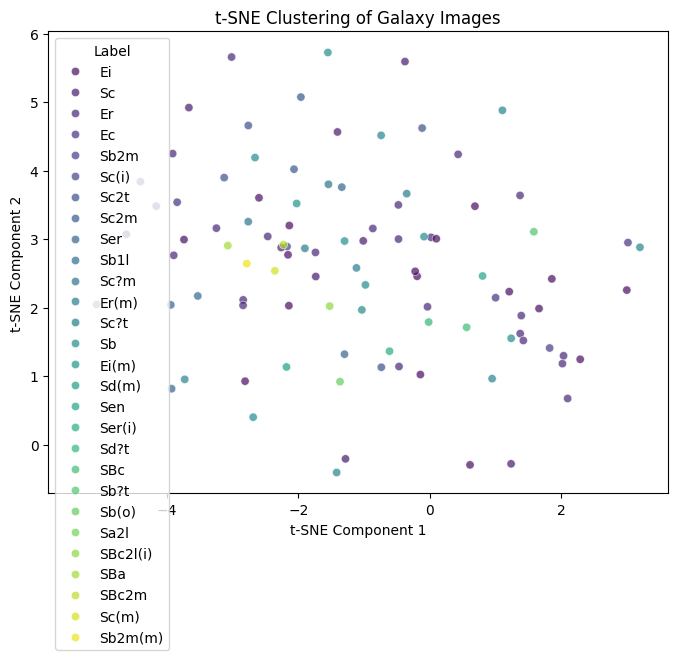

In [31]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Convert PCA-reduced data to numpy array (excluding metadata columns)
X_pca = galaxy_data_pca.iloc[:, 2:-1].values  # Excluding "objectid", "asset_id", and "gz2class"

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=galaxy_data_pca["gz2class"], palette="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Clustering of Galaxy Images")
plt.legend(title="Label")
plt.show()

**Conclusion**: Points are scattered randomly, this suggests weak separation, meaning pixel features alone might not be enough.

### 6. Build the classifier using Random Forest (play with different  depth and number of trees) or SVC.

### 1. Import libraries and Split data 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the class with only one member
class_counts = galaxy_data_pca["gz2class"].value_counts()
class_to_remove = class_counts[class_counts == 1].index

df_filtered = galaxy_data_pca[~galaxy_data_pca["gz2class"].isin(class_to_remove)]

# Prepare the data again (after removing the class)
X_filtered = df_filtered.iloc[:, 2:-1].values
y_filtered = df_filtered["gz2class"].values

# Split dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)


#### 2. Train the Random Forest Model

In [36]:
# Initialize Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train on the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Evaluate the model

Test Accuracy: 0.2353
Classification Report:
               precision    recall  f1-score   support

          Ec       0.00      0.00      0.00         1
          Ei       0.00      0.00      0.00         3
          Er       0.29      0.80      0.42         5
       Er(m)       0.00      0.00      0.00         1
          Sb       0.00      0.00      0.00         2
          Sc       0.00      0.00      0.00         1
        Sc2t       0.00      0.00      0.00         1
        Sc?m       0.00      0.00      0.00         1
        Sc?t       0.00      0.00      0.00         1
         Ser       0.00      0.00      0.00         1

    accuracy                           0.24        17
   macro avg       0.03      0.08      0.04        17
weighted avg       0.08      0.24      0.12        17



/home/christian/miniconda3/envs/group_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/christian/miniconda3/envs/group_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/christian/miniconda3/envs/group_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

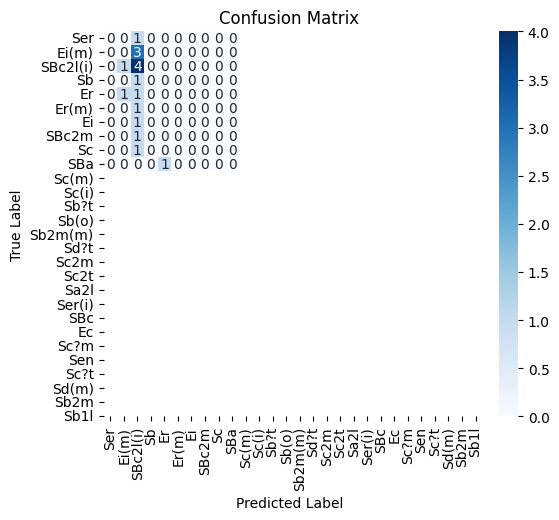

In [37]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=set(y), yticklabels=set(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### UMAP Visualization 

import umap

# Apply UMAP to reduce to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_pca)

# Plot UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=galaxy_data_pca["label"], palette="coolwarm", alpha=0.7)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Clustering of Galaxy Images")
plt.legend(title="Label")
plt.show()


# Utility function to read Images

In [11]:
#Using PILLOW to convert images to array
from PIL import Image, ImageOps
from numpy import asarray
 
 
# load the image and convert into numpy array
img = Image.open('data/images/6994.jpg') 

img_gray = ImageOps.grayscale(img)

#img_gray.show() #to check it become gray
 
# asarray() class is used to convert
# PIL images into NumPy arraystotal_classifications
numpydata = asarray(img_gray)


# EDA, feature preprocessing and classification

1. Convert array of pixels in rows of a tabular dataset,
   using single pixels as feature columns and the intensities as values measured 
   
   
2. Perform EDA and feature preprocessing

3. Estimate the symmetry of the preprocessed images with respect to 12 axes and add this info to the original data

3. Test how much you can reduce the dimensions of the problem with one algorithm between (PCA, kPCA ..)


5. Check how many clusters can be associated to the data points joint distribution using tSNE or UMAP

6. Build the classifier using Random Forest (play with different  depth and number of trees) or SVC

7. Train the classifier

8. Predict the class labels


# Evaluate the accuracy of the Classifier
## Plot Confusion matrix